## 4.1 问题一

### 4.1.1 分析与聚类

本研究基于学历要求、经验要求和平均薪资水平对全体职位进行 K-means 聚类

In [12]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

In [13]:
# Load data
df = pd.read_csv('data/final/FixedSalaryFinal.csv')
df['salary_avg'] = (df['salary_max'] + df['salary_min']) / 2

In [14]:
# One-hot encode 'experience' and 'education' columns
standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(df[['salary_max', 'salary_min']])

one_hot_encoder = OneHotEncoder()
encoded_data = one_hot_encoder.fit_transform(df[['education', 'experience']])

In [15]:
# Convert encoded data to DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), index=df.index, columns=one_hot_encoder.get_feature_names_out(['education', 'experience']))
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=['salary_max', 'salary_min'])

In [16]:
# Concatenate encoded and scaled data
concat_df = pd.concat([encoded_df, scaled_df], axis=1)
concat_df['_id'] = df['_id']
vectorized_data = concat_df.groupby('_id').mean()

In [17]:
# Standardize the data
standard_scaler = StandardScaler()
vectorized_data_scaled = standard_scaler.fit_transform(vectorized_data)
vectorized_data_scaled_df = pd.DataFrame(vectorized_data_scaled, index=vectorized_data.index, columns=vectorized_data.columns)

In [18]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(vectorized_data_scaled_df)
vectorized_data_scaled_df['kmeans_cluster'] = kmeans.labels_

In [19]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_clusters = dbscan.fit_predict(vectorized_data_scaled_df.drop(columns=['kmeans_cluster']))
vectorized_data_scaled_df['dbscan_cluster'] = dbscan_clusters

In [20]:
# Perform PCA analysis
pca = PCA(n_components=2)
data_pca = pca.fit_transform(vectorized_data_scaled_df.drop(columns=['kmeans_cluster', 'dbscan_cluster']))
pca_df = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'], index=vectorized_data_scaled_df.index)
pca_df['KMeans_Cluster'] = vectorized_data_scaled_df['kmeans_cluster']
pca_df['DBSCAN_Cluster'] = vectorized_data_scaled_df['dbscan_cluster']

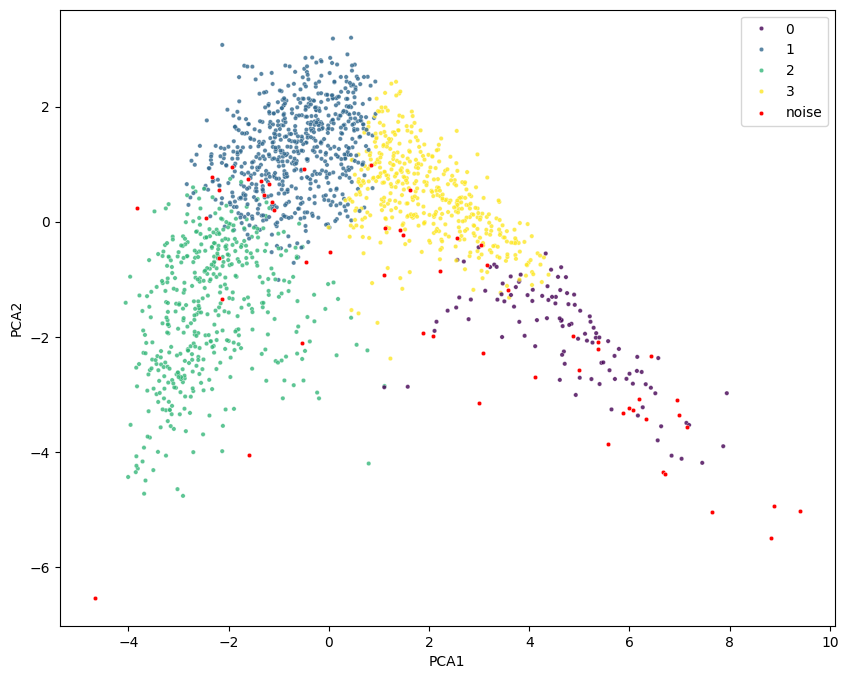

In [21]:
plt.figure(figsize=(10, 8))
# 区分 KMeans 聚类点
sns.scatterplot(
    data=pca_df[pca_df['DBSCAN_Cluster'] != -1],
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='viridis', legend='full', s=10, alpha=0.8,
)
# 覆盖 DBSCAN 的离群值
sns.scatterplot(
    data=pca_df[pca_df['DBSCAN_Cluster'] == -1],
    x='PCA1', y='PCA2',
    color='red', s=10, alpha=1, label='noise'
)

plt.legend(title='')
plt.show()

In [22]:
# Merge PCA results with original data
df['KMeans_Cluster'] = df['_id'].map(pca_df['KMeans_Cluster'])
df['DBSCAN_Cluster'] = df['_id'].map(pca_df['DBSCAN_Cluster'])
df = df[df['DBSCAN_Cluster'] != -1]

In [23]:
education_order = ['Gh', 'Go', 'GP', 'GI', 'Gy', 'Gx', 'GZ', 'Gw', 'Gi', 'GJ', 'Gz']
experience_order = ['ESu', 'Eby', 'EzN', 'EaZ', 'EdD', 'Eqh', 'Eas', 'EKk']

In [24]:
df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
df['experience'] = pd.Categorical(df['experience'], categories=experience_order, ordered=True)

In [25]:
education_distribution = df.groupby('KMeans_Cluster')['education'].value_counts(normalize=True).rename('proportion').reset_index()
experience_distribution = df.groupby('KMeans_Cluster')['experience'].value_counts(normalize=True).rename('proportion').reset_index()

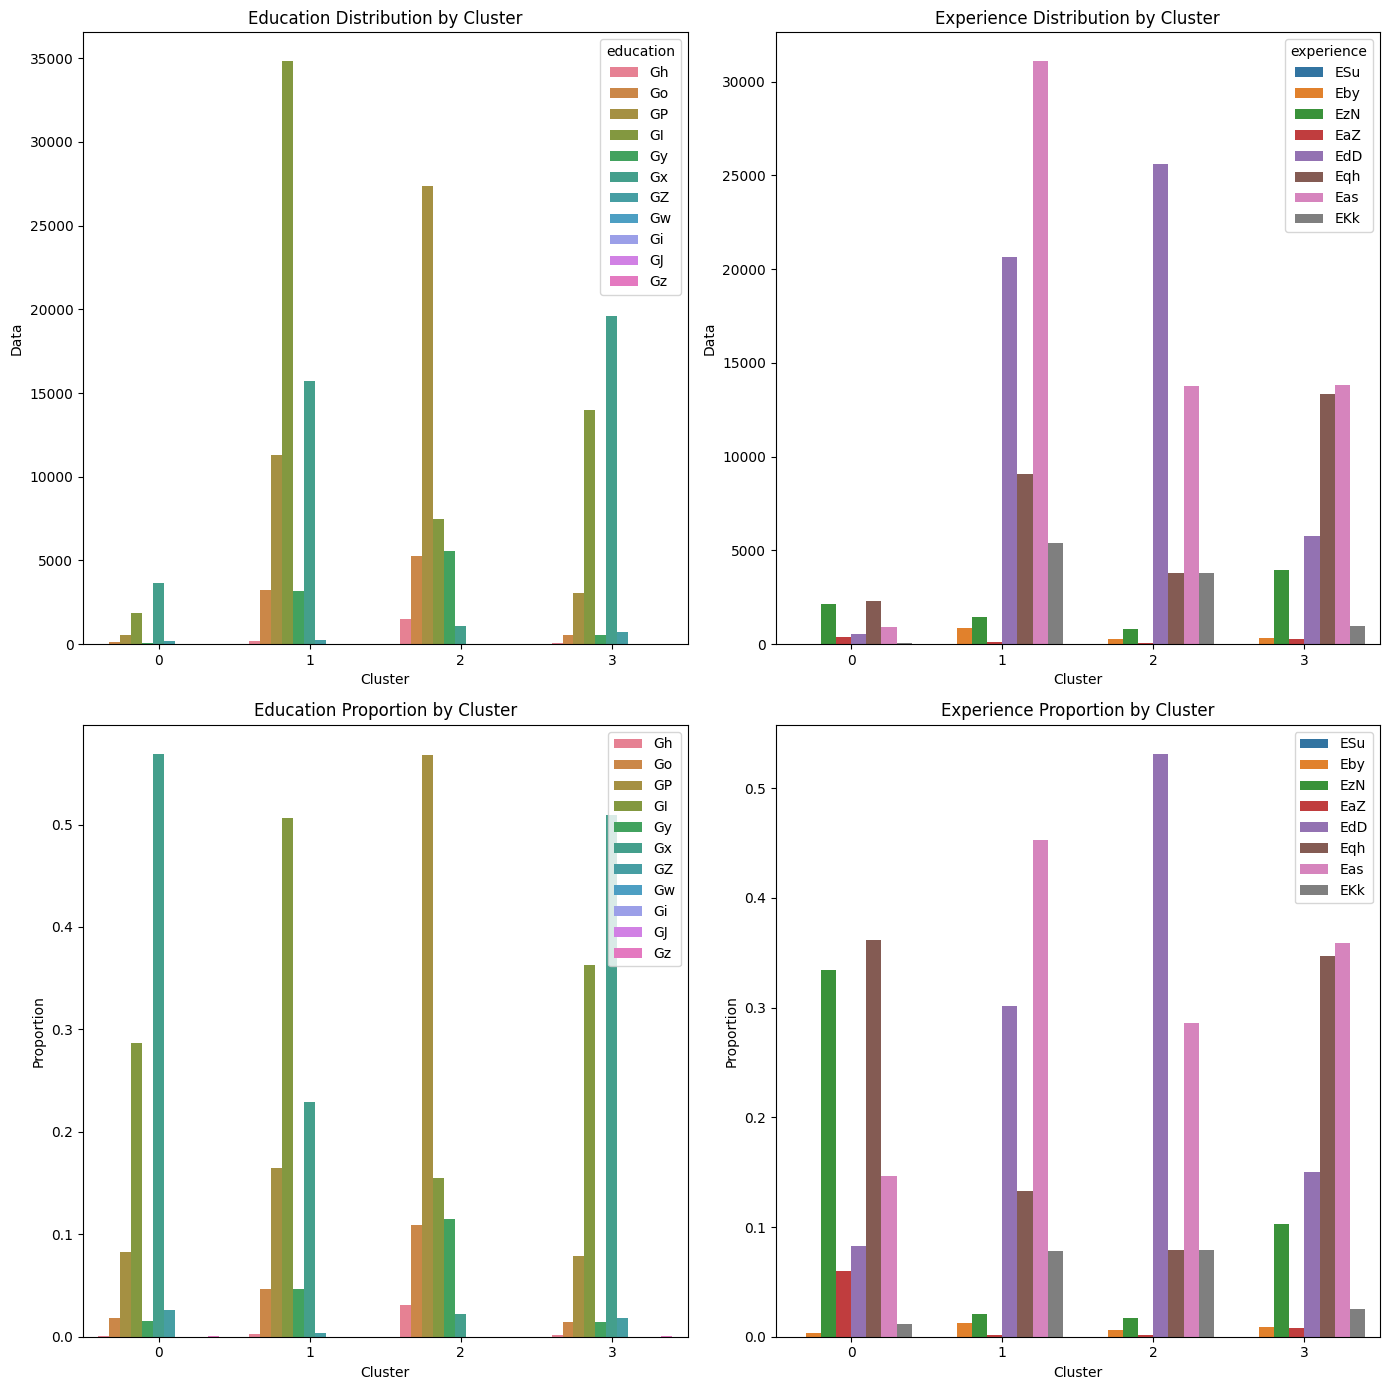

In [26]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
sns.countplot(x='KMeans_Cluster', hue='education', data=df)
plt.title('Education Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Data')

plt.subplot(2, 2, 2)
sns.countplot(x='KMeans_Cluster', hue='experience', data=df)
plt.title('Experience Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Data')

plt.subplot(2, 2, 3)
sns.barplot(x='KMeans_Cluster', y='proportion', hue='education', data=education_distribution)
plt.title('Education Proportion by Cluster')
plt.legend(loc='upper right')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

plt.subplot(2, 2, 4)
sns.barplot(x='KMeans_Cluster', y='proportion', hue='experience', data=experience_distribution)
plt.title('Experience Proportion by Cluster')
plt.legend(loc='upper right')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()